In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import shap

In [16]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
print(df.head())

   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1         125/80          75      

In [17]:
print(df.isnull().sum())  # No missing values in this dataset

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


In [18]:
# Label encode 'Gender' (Male: 0, Female: 1)
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# One-hot encode 'Occupation'
df = pd.get_dummies(df, columns=['Occupation'], drop_first=True)

# Encode target variable 'Sleep Disorder' (None:0, Insomnia:1, Sleep Apnea:2)
df['Sleep Disorder'] = df['Sleep Disorder'].map({'None': 0, 'Insomnia': 1, 'Sleep Apnea': 2})

In [19]:
df.drop('Person ID', axis=1, inplace=True)  # Not useful for prediction

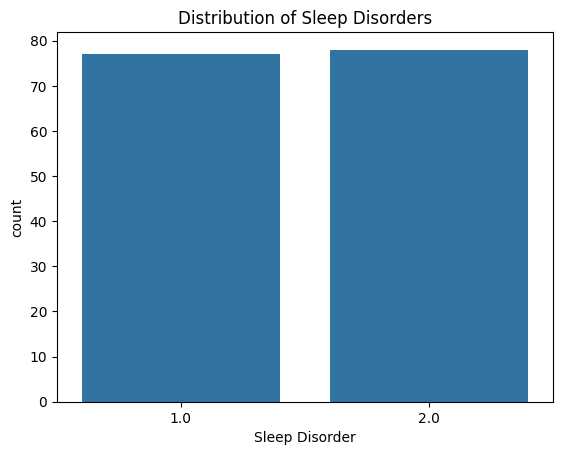

In [20]:
sns.countplot(x=df['Sleep Disorder'])
plt.title("Distribution of Sleep Disorders")
plt.show()

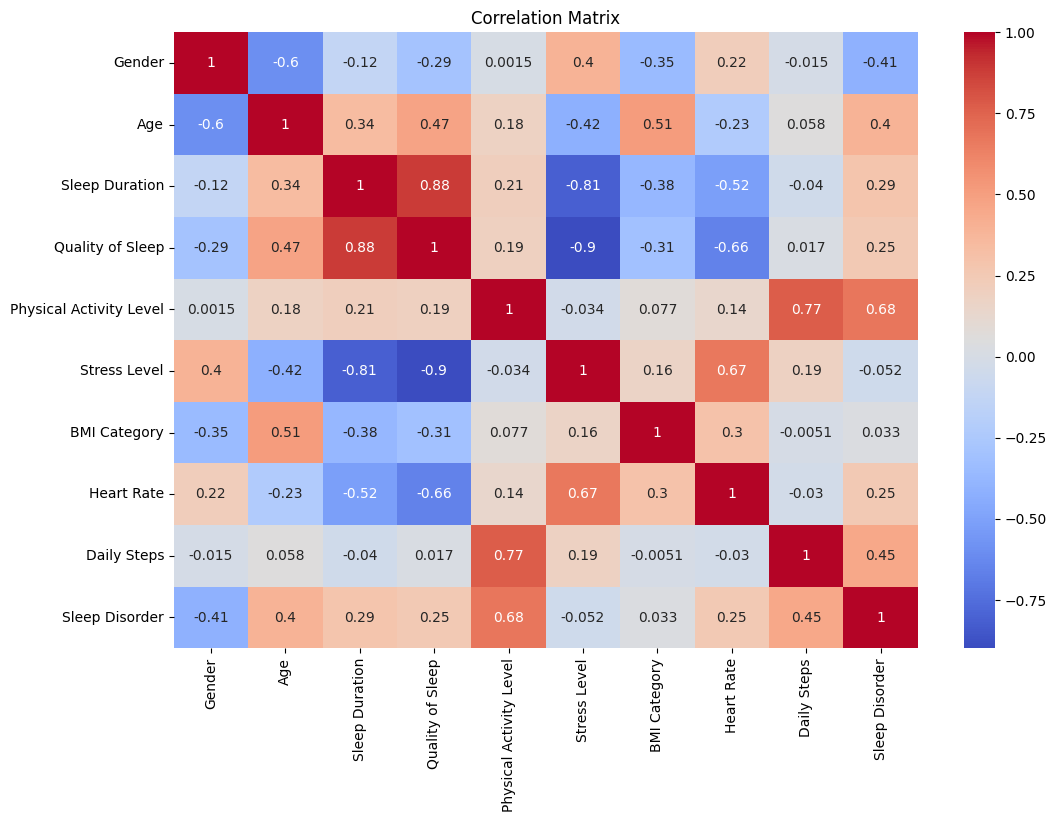

In [21]:
# Encode categorical columns (if needed)
df['BMI Category'] = LabelEncoder().fit_transform(df['BMI Category'])
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# Select only numerical columns (optional)
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')  # or use `df.corr()` if all columns are encoded
plt.title("Correlation Matrix")
plt.show()

In [22]:
X = df.drop('Sleep Disorder', axis=1)
y = df['Sleep Disorder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load data
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

## ====================== DATA CLEANING ====================== ##

# 1. Handle missing values in target
print("Missing values in target before:", df['Sleep Disorder'].isna().sum())
df = df.dropna(subset=['Sleep Disorder'])  # Remove rows with missing target
print("Missing values in target after:", df['Sleep Disorder'].isna().sum())

# 2. Process Blood Pressure (convert '130/85' to two numerical columns)
df[['BP_Systolic', 'BP_Diastolic']] = (
    df['Blood Pressure'].str.split('/', expand=True).astype(float)
)
df.drop('Blood Pressure', axis=1, inplace=True)

# 3. Convert all categorical features to numerical
# Gender (binary)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

# BMI Category (ordinal)
bmi_mapping = {'Normal': 0, 'Overweight': 1, 'Obese': 2}
df['BMI Category'] = df['BMI Category'].map(bmi_mapping)

# Occupation (one-hot encoding)
df = pd.get_dummies(df, columns=['Occupation'], drop_first=True)

# Sleep Disorder (target)
df['Sleep Disorder'] = df['Sleep Disorder'].map({
    'None': 0, 
    'Insomnia': 1, 
    'Sleep Apnea': 2
})

## ====================== MODEL TRAINING ====================== ##

# Prepare features and target
X = df.drop([
    'Person ID', 
    'Sleep Disorder'  # Target variable
], axis=1)

y = df['Sleep Disorder']

# Verify no missing values remain
print("\nMissing values in features:")
print(X.isna().sum())

print("\nMissing values in target:")
print(y.isna().sum())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestClassifier(
    class_weight='balanced',  # Handles class imbalance
    random_state=42,
    n_estimators=100
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Missing values in target before: 219
Missing values in target after: 0

Missing values in features:
Gender                             0
Age                                0
Sleep Duration                     0
Quality of Sleep                   0
Physical Activity Level            0
Stress Level                       0
BMI Category                       4
Heart Rate                         0
Daily Steps                        0
BP_Systolic                        0
BP_Diastolic                       0
Occupation_Doctor                  0
Occupation_Engineer                0
Occupation_Lawyer                  0
Occupation_Nurse                   0
Occupation_Sales Representative    0
Occupation_Salesperson             0
Occupation_Scientist               0
Occupation_Software Engineer       0
Occupation_Teacher                 0
dtype: int64

Missing values in target:
0

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.86      

In [32]:
# If shap_array has 3 dimensions, pick the last dimension (class) you want:
if shap_array.ndim == 3:
    shap_array = shap_array[:, :, 1]  # select class 1 shap values

# Now check shape again
if shap_array.shape != X_test.shape:
    raise ValueError(f"SHAP array shape {shap_array.shape} does not match X_test shape {X_test.shape}")

# Continue with your existing code
summary = pd.DataFrame(shap_array, columns=X_test.columns).abs().mean().sort_values(ascending=False)

In [33]:
summary

BP_Diastolic                       0.085996
BP_Systolic                        0.060703
Physical Activity Level            0.058871
Occupation_Nurse                   0.047937
Daily Steps                        0.040068
Age                                0.036785
Heart Rate                         0.033940
Sleep Duration                     0.032961
Stress Level                       0.031209
Quality of Sleep                   0.015551
Gender                             0.013731
BMI Category                       0.009425
Occupation_Teacher                 0.007510
Occupation_Sales Representative    0.005017
Occupation_Salesperson             0.003696
Occupation_Software Engineer       0.002465
Occupation_Lawyer                  0.002444
Occupation_Doctor                  0.002406
Occupation_Engineer                0.002243
Occupation_Scientist               0.001514
dtype: float64

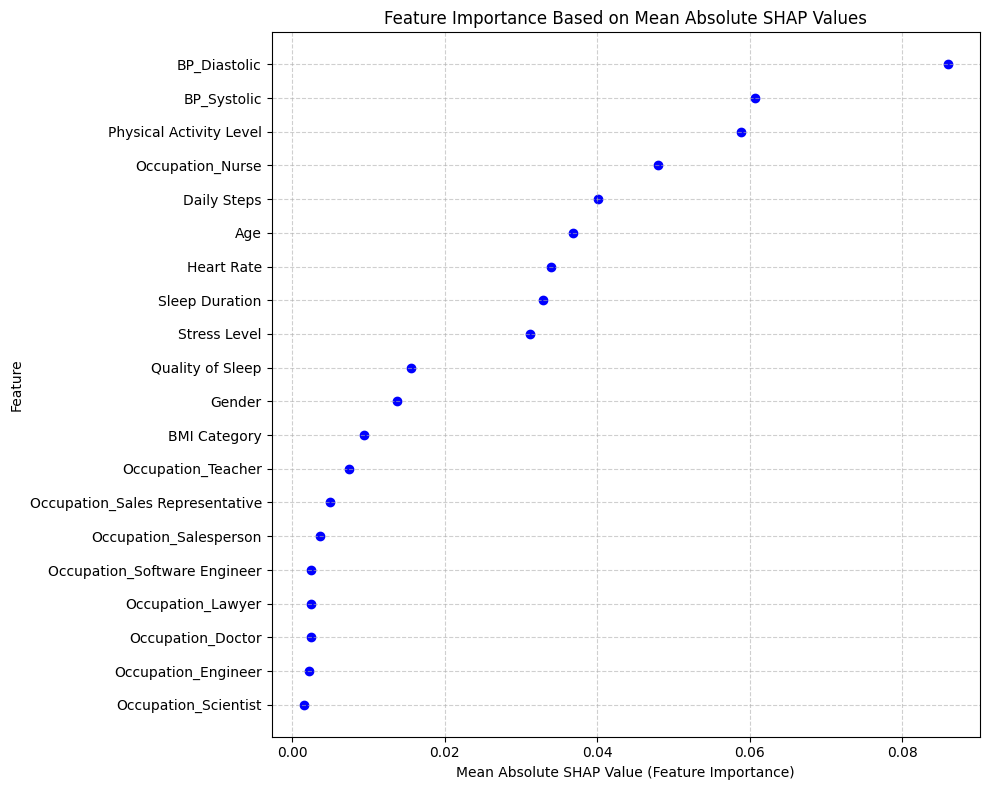

In [34]:
import matplotlib.pyplot as plt

# Assuming 'summary' is your pandas Series with SHAP values indexed by feature names
summary = summary.sort_values(ascending=True)  # sort ascending for better visual

plt.figure(figsize=(10, 8))
plt.scatter(summary.values, summary.index, color='blue')
plt.xlabel('Mean Absolute SHAP Value (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance Based on Mean Absolute SHAP Values')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()